### This script has been run on the models created on TPU to test and compute performance metrics for various thresholds

In [1]:
!pip install -q efficientnet >> /dev/null

In [1]:
import numpy as np 
import pandas as pd

import tensorflow as tf
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import re, math
import time

In [2]:
# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
DEVICE = "GPU" # or "TPU"

# TFRecords file for training/validation
DIR_TFREC = './tfrec'
DIR_MODELS = './tpu-models'

IMG_SIZES = 512

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]

# tune it, dependes on Image, size, TPU or GPU
#BATCH_SIZE = 64
BATCH_SIZE = 26

EPOCHS = 50

# for K-fold CV
FOLDS = 5

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 4

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


In [5]:
def read_labeled_tfrecord_for_test(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # DON't do image augmentation
    label = example['label']
        
    return image, label 

def decode_image(image_data):
    # qua dovrebbe fare la conversione in RGB come richiesto da EfficientNet
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [6]:
def load_dataset(filenames, labeled=True, ordered=False, isTest=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    
    if isTest == False:
        dataset = dataset.map(read_labeled_tfrecord)
    else:
        dataset = dataset.map(read_labeled_tfrecord_for_test)
    
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_test_dataset(filenames):
    # for predictions it is crucial the ordering
    dataset = load_dataset(filenames, labeled=True, isTest = True, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [7]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = IMG_SIZES, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    # removed label smoothing
    fn_loss = tf.keras.losses.BinaryCrossentropy() 
    
    # loss = [focal_loss]
    model.compile(optimizer = opt, loss = [fn_loss], metrics=['AUC', 'accuracy'])
    
    return model

In [8]:
# compute on test set, No augmentation

files_test = tf.io.gfile.glob(DIR_TFREC + '/test*.tfrec')

num_total_test_files = len(files_test)

In [9]:
# all the label from the test dataset
y_true = np.concatenate([y for x, y in get_test_dataset(files_test)], axis=0)

In [10]:
avg_preds = np.zeros((count_data_items(files_test), 1))

# to remove model loading time from time computation
models = []

print('Loading models...')

# load all the 5 models
for fold in range(1, FOLDS + 1):
    model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    model.load_weights(DIR_MODELS + '/fold-%i.h5'%fold)
    
    models.append(model)

tStart = time.time()

for fold in range(1, FOLDS + 1):
    print('Predicting  on fold:', fold)
    
    model = models[fold -1]
    
    preds = model.predict(get_test_dataset(files_test), verbose = True,
                          steps = count_data_items(files_test)/BATCH_SIZE)
    
    avg_preds += preds * 1./FOLDS

tEla = time.time() - tStart

print('Time for all predictions: ', round(tEla, 1))

Loading models...
71892992/71892840 [==============================] - 1s 0us/step
Predicting  on fold: 1
25/24 [==============================] - 38s 2s/step
Predicting  on fold: 2
25/24 [==============================] - 32s 1s/step
Predicting  on fold: 3
25/24 [==============================] - 32s 1s/step
Predicting  on fold: 4
25/24 [==============================] - 32s 1s/step
Predicting  on fold: 5
25/24 [==============================] - 32s 1s/step
Time for all predictions:  166.7


### compute the ROC_AUC_CURVE

In [11]:
from sklearn.metrics import roc_curve

In [12]:
fpr, tpr, thresholds = roc_curve(y_true, avg_preds)

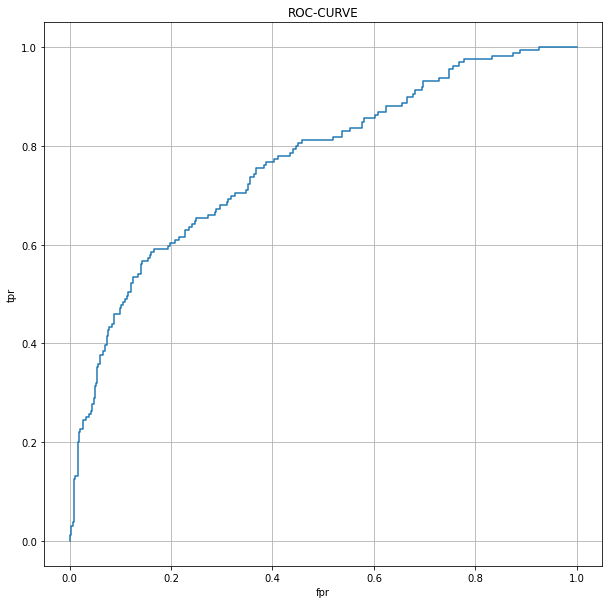

In [13]:
plt.figure(figsize=(10,10))
plt.title('ROC-CURVE')
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid()